## Feature extraction
In this notebook an approach to preprocessing microphone data is explored. The idea is to group individual readings from a 8-channel audio recording into sequences longer sequences (for example of length 20). This will effectively create a list of matrices from the original data. Then, each matrix can be used to extract individual channel data and compute generalized cross-correlation (GCC-PHAT) between each pair of microphones.

#### Imports

In [1]:
import numpy as np
import pandas as pd
import os
from itertools import combinations
from statistics import mode
import matplotlib.pyplot as plt
import math
from scipy.signal import correlate
from scipy.io import wavfile

#### GCC-PHAT computation
Here the function for computing GCC is defined:

In [95]:
def gcc_phat(x_1, x_2, FS=16000):
    """
    Function that will compute the GCC-PHAT
    cross-correlation of two separate audio channels
    
    Returns:
        A 1-D GCC vector
    """
    
    n = len(x_1) + len(x_2) - 1
    n += 1 if n % 2 else 0
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
     # Normalize by the magnitude of FFT - because PHAT
    np.divide(X_1, np.abs(X_1), X_1, where=np.abs(X_1) != 0)
    np.divide(X_2, np.abs(X_2), X_2, where=np.abs(X_2) != 0)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See http://www.xavieranguera.com/phdthesis/node92.html for reference
    CC = X_1 * np.conj(X_2)
    cc = np.fft.irfft(CC, n=n)
        
    # Maximum delay between a pair of microphones,
    # expressed in a number of samples.
    # 0.09 m is the mic array diameter and 
    # 340 m/s is assumed to be the speed of sound.
    max_len = math.ceil(0.09 / 340 * FS)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc

Let's test the above function and plot an example cross-correlation between an arbitrary signal and its noisy version:

In [59]:
sig = np.repeat([0., 1., 1., 0., 1., 0., 0., 1.], 128)
sig_noise = sig + np.random.randn(len(sig))

[ 0.01645501  0.04331462  0.0560153   0.04303744 -0.00949148  0.10544962
  0.03557008  0.02298507 -0.00909829  0.02562861  0.02351   ]


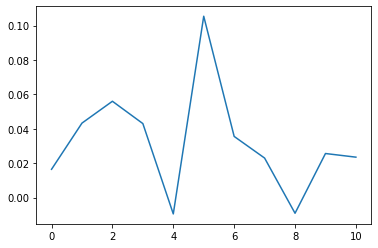

In [100]:
gcc = gcc_phat(sig, sig_noise)
print(gcc)
plt.plot(gcc)
plt.show()

#### Creating observations
In the following code cell one can find a function that accepts a pandas dataframe containing rows of consecutive readings from a microphone array and transforms it into a list of GCC matrices.

In [76]:
def create_observations(wav_signals, fs, label, samples=1, step=1, resolution=20):
    """
    Create list of observations from the pandas dataframe.
    Each observation will be a GCC matrix, where each row is a vector
    of GCC between a given pair of microphones.
    
    Returns: 
        a tuple of observations and their corresponding labels
    """
    
    # Lists of observations and labels that will be populated
    X = []
    y = []
    
    # Loop through the signal frame and take subframes
    for i in range(0, len(wav_signals) - samples + 1, step):
        rounded_label = math.floor(label / resolution) * resolution
        y.append(rounded_label)
        
        # Extract the observation from subframe
        observation = np.array(wav_signals[i : i + samples])
        
        mic_pairs = combinations(range(6), r=2)
        
        # Initialize a transformed observation, that will be populated with GCC vectors
        # of the observation
        transformed_observation = []
        
        # Compute GCC for every pair of microphones
        for mic_1, mic_2 in mic_pairs:
            x_1 = observation[:, mic_1]
            x_2 = observation[:, mic_2]
            
            gcc = gcc_phat(x_1, x_2, FS=fs)
            
            # Add the GCC vector to the GCC matrix
            transformed_observation.append(gcc)
            
        # Add the GCC matrix to the list of observations
        X.append(transformed_observation)
        
    return X, y

#### Testing the function to create observations

In [79]:
path = os.path.join('..', 'training_data', 'angle_0_CantinaBand3.wav')
fs, audio = wavfile.read(path)

X, y = create_observations(audio, fs, 10, samples=2205, step=2000, resolution=20)

print('X shape: ' + str(np.shape(X)))
print('y shape: ' + str(np.shape(y)))

X shape: (332, 15, 13)
y shape: (332,)


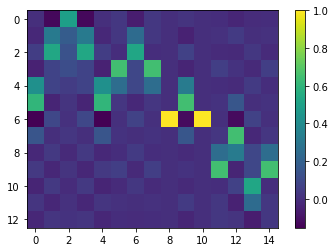

In [80]:
plt.imshow(np.transpose(X[-1]))
plt.colorbar()
plt.show()

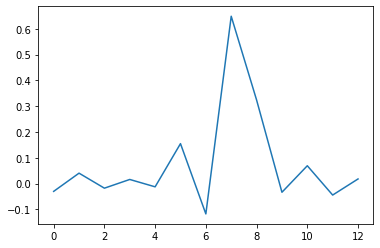

In [81]:
plt.plot(X[-1][12])
plt.show()